# aai-510-group2-final-project

# Cluster Quest - Mapping Social Cohorts in Facebook Networks

## Team Members:

Alejandro Marchini

Carlos Alberto Ortiz Montes De Oca

Swathi Subramanyam Pabbathi

In [5]:
pip install -r requirements.txt

  Using cached python_igraph-0.11.8-py3-none-any.whl.metadata (2.8 kB)
  Using cached igraph-0.11.8-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [python-igraph]0m [igraph]
Note: you may need to restart the kernel to use updated packages.


In [1]:
# import all necessary libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from math import log
import networkx as nx
from igraph import Graph, plot
import igraph as ig
from math import log
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


In [2]:
nx_graph = nx.read_edgelist('facebook_combined.txt', create_using = nx.Graph(), nodetype = int)


igraph_fb = Graph.Read_Edgelist('facebook_combined.txt', directed=False)

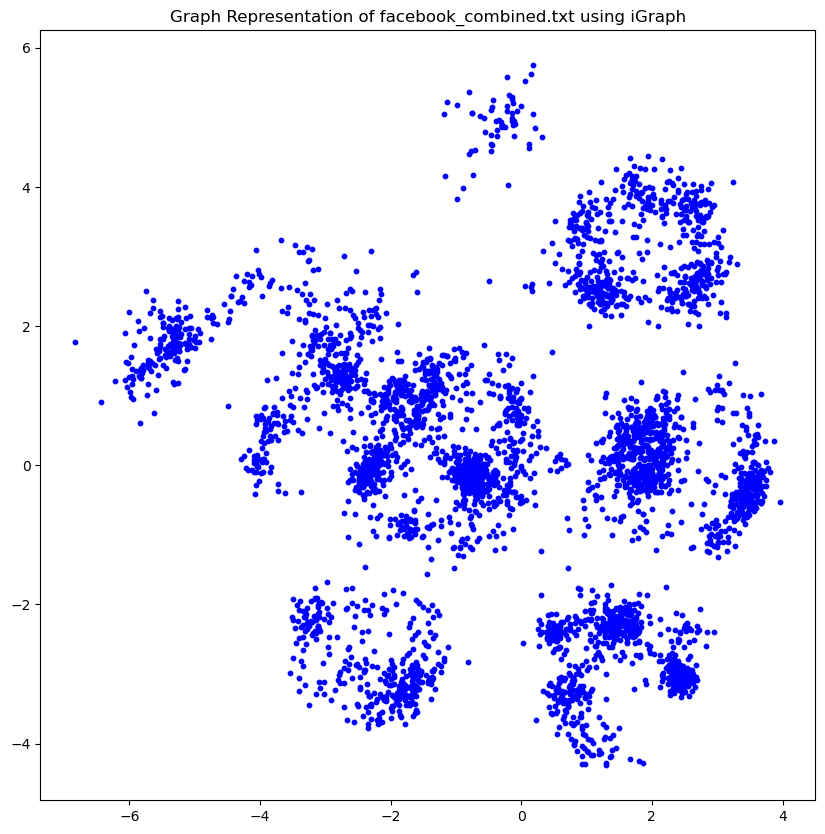

In [3]:
# Plot the graph layout
layout = igraph_fb.layout("fr")  # Fruchterman-Reingold force-directed algorithm layout

# Get node coordinates
node_positions = [(layout[x][0], layout[x][1]) for x in range(len(layout))]

# Create a scatter plot using Matplotlib
plt.figure(figsize=(10, 10))
plt.scatter(*zip(*node_positions), color='blue', s=10)  # Scatter plot of node positions
plt.title('Graph Representation of facebook_combined.txt using iGraph')
plt.show()

In [4]:
# Check whether the graph is connected
is_connected = igraph_fb.is_connected()
print(f"Is the graph connected? {is_connected}")

Is the graph connected? True


In [5]:
# Find any single nodes or no nodes
num_nodes = len(igraph_fb.vs)
print(f"Number of nodes: {num_nodes}")

Number of nodes: 4039


In [6]:
# determine if are there are any self loops or self nodes and if exists remove them
igraph_fb = igraph_fb.simplify()  # Remove self-loops and multiple edges
igraph_fb = igraph_fb.subgraph([v for v in igraph_fb.vs if v.degree() > 0])  # Remove isolated nodes


In [7]:
# igraph_fb is my graph object
# Extracting global node features
degree = igraph_fb.degree()
clustering_coeff = igraph_fb.transitivity_local_undirected()
betweenness_centrality = igraph_fb.betweenness()
closeness_centrality = igraph_fb.closeness()
pagerank = igraph_fb.pagerank()
katz_centrality = igraph_fb.personalized_pagerank(damping=0.85)
hub_scores = igraph_fb.hub_score()
authority_scores = igraph_fb.authority_score()
eigenvector_centrality = igraph_fb.eigenvector_centrality()
eccentricity = igraph_fb.eccentricity()
constraint = igraph_fb.constraint()
core_number = igraph_fb.coreness()

# Initialize lists to store 2-hop local features
mean_neighbor_degree = []
local_cluster_sizes = []
local_cluster_densities = []
local_cluster_assortativities = []
average_degree_local_clusters = []
local_clustering_coeff = []
sorensen_indices = []
adamic_adar_indices = []

# Function to calculate Sorensen index between two sets
def sorensen_index(set1, set2):
    intersection = len(set1.intersection(set2))
    return 2 * intersection / (len(set1) + len(set2))

# Function to calculate Adamic-Adar index between two sets
def adamic_adar_index(set1, set2, degrees):
    common_neighbors = set1.intersection(set2)
    return sum(1 / log(degrees[neighbor]) for neighbor in common_neighbors if degrees[neighbor] > 1)

# Compute 2-hop local features
for vertex in igraph_fb.vs:
    neighbors = igraph_fb.neighborhood(vertex.index, order=2)
    subgraph = igraph_fb.subgraph(neighbors)

    mean_neighbor_degree.append(np.mean(subgraph.degree()))
    local_cluster_sizes.append(len(subgraph.vs))
    local_cluster_densities.append(subgraph.density())
    local_cluster_assortativities.append(subgraph.assortativity_degree(directed=False))
    average_degree_local_clusters.append(np.mean(subgraph.degree()))

    # Compute the local clustering coefficient for each vertex in its 2-hop subgraph
    subgraph_clustering_coeff = subgraph.transitivity_local_undirected()
    if len(subgraph_clustering_coeff) > 0:
        local_clustering_coeff.append(np.mean(subgraph_clustering_coeff))
    else:
        local_clustering_coeff.append(0)  # Append 0 if no clustering coefficient is available

    # Compute Sorensen index for each vertex in its 2-hop subgraph
    sorensen_values = []
    adamic_adar_values = []
    for neighbor in neighbors:
        if vertex.index != neighbor:
            v_neighbors = set(igraph_fb.neighborhood(vertex.index))
            n_neighbors = set(igraph_fb.neighborhood(neighbor))
            sorensen_values.append(sorensen_index(v_neighbors, n_neighbors))
            adamic_adar_values.append(adamic_adar_index(v_neighbors, n_neighbors, degree))

    if len(sorensen_values) > 0:
        sorensen_indices.append(np.mean(sorensen_values))
    else:
        sorensen_indices.append(0)  # Append 0 if no Sorensen index is available

    if len(adamic_adar_values) > 0:
        adamic_adar_indices.append(np.mean(adamic_adar_values))
    else:
        adamic_adar_indices.append(0)  # Append 0 if no Adamic-Adar index is available

# Calculate the number of triangles each node is part of
num_triangles = [tc * (d * (d - 1)) / 2 for tc, d in zip(clustering_coeff, degree)]

# For completeness, we can calculate the core number
core_number = igraph_fb.coreness()

# Calculate bridging centrality, avoiding division by zero
#bridging_centrality = [
#    (bc / cc if cc != 0 else 0)  # Avoid division by zero by using 0 when cc is 0
#    for bc, cc in zip(betweenness_centrality, clustering_coeff)
# Removed this feature as it is graph level feature and project a single value in the dataframe.

In [8]:
# Initialize participation coefficient list
participation_coefficient = []

# Calculate participation coefficient for each node
for vertex in igraph_fb.vs:
    node_id = vertex.index
#    communities = set(membership[neighbor] for neighbor in igraph_fb.neighbors(node_id))
    k_i = igraph_fb.degree(node_id)
    if k_i == 0:
        participation_coefficient.append(0.0)
        continue
    sum_fraction = sum((igraph_fb.degree(neighbor) / k_i) ** 2 for neighbor in igraph_fb.neighbors(node_id))
    participation_coeff = 1 - sum_fraction
    participation_coefficient.append(participation_coeff)


In [9]:

# Calculate local efficiency for each node
local_efficiency_values = []

for node in igraph_fb.vs:
    neighbors = igraph_fb.neighbors(node.index)

    # Create subgraph with the node and its neighbors
    subgraph = igraph_fb.subgraph([node.index] + neighbors)

    # Calculate global efficiency of the subgraph
    if len(subgraph.vs) > 1:  # Ensure subgraph has more than one node
        global_efficiency = subgraph.transitivity_undirected()
    else:
        global_efficiency = 0.0  # If subgraph has only one node, efficiency is 0

    # Local efficiency of the node is the global efficiency of its subgraph
    local_efficiency_values.append(global_efficiency)



In [10]:
# Create a DataFrame with the extracted features
df = pd.DataFrame({
    'Node': [v.index for v in igraph_fb.vs],
    'Degree': degree,
    'ClusteringCoefficient': clustering_coeff,
    'BetweennessCentrality': betweenness_centrality,
    'ClosenessCentrality': closeness_centrality,
    'PageRank': pagerank,
    'katz_centrality ' : katz_centrality,
    'EigenvectorCentrality': eigenvector_centrality,
    'HubScore': hub_scores,
    'AuthorityScore': authority_scores,
    'Eccentricity': eccentricity,
    'Constraint': constraint,
    'LocalEfficiency': local_efficiency_values,
    'NumTriangles': num_triangles,
    'MeanNeighborDegree': mean_neighbor_degree,
    'LocalClusterSizes': local_cluster_sizes,
    'LocalClusterDensities': local_cluster_densities,
    'LocalClusterAssortativities': local_cluster_assortativities,
    'AverageDegreeLocalClusters': average_degree_local_clusters,
    'local_clustering_coeff': local_clustering_coeff,
    'sorensen_indices': sorensen_indices,
    'adamic_adar_indices': adamic_adar_indices,
    'CoreNumber': core_number,
    'participation_coefficient' : participation_coefficient


})

## Additional community features

In [11]:
# Perform community detection using the Louvain method
louvain_partition = igraph_fb.community_multilevel()
membership = louvain_partition.membership

# Perform community detection
communities = igraph_fb.community_fastgreedy().as_clustering()

# Calculate community metrics
community_size = [0] * len(igraph_fb.vs)
community_density = [0.0] * len(igraph_fb.vs)
community_assortativity = [0.0] * len(igraph_fb.vs)

unique_communities = set(communities.membership)
for comm_id in unique_communities:
    nodes_in_community = [node.index for node in igraph_fb.vs if communities.membership[node.index] == comm_id]

    # Community Size
    size = len(nodes_in_community)
    for node_idx in nodes_in_community:
        community_size[node_idx] = size

    # Community Density
    subgraph = igraph_fb.subgraph(nodes_in_community)
    density = subgraph.density()
    for node_idx in nodes_in_community:
        community_density[node_idx] = density

    # Community Assortativity
    assortativity = subgraph.assortativity_degree(directed=False)
    for node_idx in nodes_in_community:
        community_assortativity[node_idx] = assortativity

# Create or update DataFrame with node-level features and community-level features
df['Communities'] = communities.membership
df['CommunitySize'] = community_size
df['CommunityDensity'] = community_density
df['CommunityAssortativity'] = community_assortativity

In [12]:
df.shape

(4039, 28)

In [13]:
df.head(10)

,Node,Degree,ClusteringCoefficient,BetweennessCentrality,ClosenessCentrality,PageRank,katz_centrality,EigenvectorCentrality,HubScore,AuthorityScore,...,AverageDegreeLocalClusters,local_clustering_coeff,sorensen_indices,adamic_adar_indices,CoreNumber,participation_coefficient,Communities,CommunitySize,CommunityDensity,CommunityAssortativity
0,0,347,0.041962,1.192496e+06,0.353343,0.006225,0.006225,0.000347,0.000347,0.000347,...,44.358130,NaN,0.023862,1.399413,21,-9.603966,0,372,0.042446,-0.133841
1,1,17,0.419118,2.268564e+01,0.261376,0.000236,0.000236,0.000006,0.000006,0.000006,...,16.471264,NaN,0.128317,0.581634,13,-483.788927,0,372,0.042446,-0.133841
2,2,10,0.888889,6.190476e-01,0.261258,0.000199,0.000199,0.000002,0.000002,0.000002,...,16.471264,NaN,0.122203,0.337811,9,-1230.810000,0,372,0.042446,-0.133841
3,3,17,0.632353,1.373447e+01,0.261376,0.000226,0.000226,0.000007,0.000007,0.000007,...,16.471264,NaN,0.143140,0.693401,13,-541.138408,0,372,0.042446,-0.133841
4,4,10,0.866667,1.500000e+00,0.261258,0.000233,0.000233,0.000002,0.000002,0.000002,...,16.471264,NaN,0.110459,0.288285,9,-1210.200000,0,372,0.042446,-0.133841
5,5,13,0.333333,1.798016e+01,0.261308,0.000202,0.000202,0.000012,0.000012,0.000012,...,16.471264,NaN,0.119667,0.454817,10,-783.532544,0,372,0.042446,-0.133841
6,6,6,0.933333,2.000000e-01,0.261190,0.000175,0.000175,0.000002,0.000002,0.000002,...,16.471264,NaN,0.126051,0.231735,5,-3350.250000,0,372,0.042446,-0.133841
7,7,20,0.431579,1.388052e+03,0.274769,0.000263,0.000263,0.000269,0.000269,0.000269,...,24.827887,NaN,0.090114,0.493943,12,-387.290000,0,372,0.042446,-0.133841
8,8,8,0.678571,2.250000e+00,0.261224,0.000231,0.000231,0.000002,0.000002,0.000002,...,16.471264,NaN,0.113541,0.248348,5,-1884.203125,0,372,0.042446,-0.133841
9,9,57,0.397243,1.341136e+02,0.262055,0.000604,0.000604,0.000023,0.000023,0.000023,...,16.471264,NaN,0.156285,1.832545,21,-66.800862,0,372,0.042446,-0.133841


In [14]:
df.tail(10)

,Node,Degree,ClusteringCoefficient,BetweennessCentrality,ClosenessCentrality,PageRank,katz_centrality,EigenvectorCentrality,HubScore,AuthorityScore,...,AverageDegreeLocalClusters,local_clustering_coeff,sorensen_indices,adamic_adar_indices,CoreNumber,participation_coefficient,Communities,CommunitySize,CommunityDensity,CommunityAssortativity
4029,4029,2,1.000000,0.000000,0.183989,0.000119,0.000119,3.050869e-09,3.050869e-09,3.050869e-09,...,6.833333,NaN,0.243867,0.343056,2,-870.250000,12,59,0.117475,-0.291613
4030,4030,19,0.368421,37.021429,0.184131,0.000553,0.000553,3.445770e-09,3.445770e-09,3.445770e-09,...,6.833333,NaN,0.277159,1.651874,7,-13.734072,12,59,0.117475,-0.291613
4031,4031,11,0.436364,13938.700000,0.224845,0.000356,0.000356,4.884414e-07,4.884414e-07,4.884414e-07,...,6.687500,NaN,0.224321,0.913924,5,-34.314050,12,59,0.117475,-0.291613
4032,4032,2,1.000000,0.000000,0.183989,0.000101,0.000101,3.070336e-09,3.070336e-09,3.070336e-09,...,6.833333,NaN,0.255154,0.355122,2,-881.500000,12,59,0.117475,-0.291613
4033,4033,3,1.000000,0.000000,0.183997,0.000124,0.000124,3.071382e-09,3.071382e-09,3.071382e-09,...,6.833333,NaN,0.248065,0.430379,3,-403.777778,12,59,0.117475,-0.291613
4034,4034,2,1.000000,0.000000,0.183989,0.000094,0.000094,3.071930e-09,3.071930e-09,3.071930e-09,...,6.833333,NaN,0.275990,0.399703,2,-950.250000,12,59,0.117475,-0.291613
4035,4035,1,NaN,0.000000,0.183980,0.000068,0.000068,3.032079e-09,3.032079e-09,3.032079e-09,...,6.833333,NaN,0.267519,0.245246,1,-3480.000000,12,59,0.117475,-0.291613
4036,4036,2,1.000000,0.000000,0.183989,0.000106,0.000106,3.051111e-09,3.051111e-09,3.051111e-09,...,6.833333,NaN,0.247768,0.343056,2,-873.250000,12,59,0.117475,-0.291613
4037,4037,4,0.666667,0.583333,0.184005,0.000148,0.000148,3.111359e-09,3.111359e-09,3.111359e-09,...,6.833333,NaN,0.255600,0.531122,4,-241.812500,12,59,0.117475,-0.291613
4038,4038,9,0.555556,5.166667,0.184047,0.000295,0.000295,9.279565e-09,9.279565e-09,9.279565e-09,...,6.833333,NaN,0.263106,0.893126,5,-52.765432,12,59,0.117475,-0.291613


### Data Preparation

In [15]:
# Count zeros in each column
zero_counts = df.eq(0).sum()

# Print the number of zeros in each column
print("Number of zeros in each column:")
print(zero_counts)

Number of zeros in each column:
Node                             1
Degree                           0
ClusteringCoefficient            1
BetweennessCentrality          342
ClosenessCentrality              0
PageRank                         0
katz_centrality                  0
EigenvectorCentrality            0
HubScore                         0
AuthorityScore                   0
Eccentricity                     0
Constraint                       0
LocalEfficiency                  1
NumTriangles                     1
MeanNeighborDegree               0
LocalClusterSizes                0
LocalClusterDensities            0
LocalClusterAssortativities      0
AverageDegreeLocalClusters       0
local_clustering_coeff           0
sorensen_indices                 0
adamic_adar_indices              0
CoreNumber                       0
participation_coefficient        0
Communities                    372
CommunitySize                    0
CommunityDensity                 0
CommunityAssortativity 

In [16]:
# Display unique values of the 'local_clustering_coeff' column
print("Unique values of local_clustering_coeff:")
print(df['local_clustering_coeff'].unique())

# Display unique values of the 'Communities' column
print("Unique values of Communities:")
print(df['Communities'].unique())

# Display unique values of the 'CommunitySize' column
print("Unique values of CommunitySize:")
print(df['CommunitySize'].unique())

# Display unique values of the 'CommunityDensity' column
print("Unique values of CommunityDensity:")
print(df['CommunityDensity'].unique())

# Display unique values of the 'CommunityAssortativity' column
print("Unique values of CommunityAssortativity:")
print(df['CommunityAssortativity'].unique())

Unique values of local_clustering_coeff:
[nan]
Unique values of Communities:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Unique values of CommunitySize:
[372 816  25 206 548 982  37 543 208 219  18   6  59]
Unique values of CommunityDensity:
[0.04244558 0.04046072 0.86666667 0.09391428 0.03573573 0.05282236
 0.73873874 0.09347414 0.71316425 0.22889699 0.79084967 0.93333333
 0.11747516]
Unique values of CommunityAssortativity:
[-0.13384127 -0.06992274 -0.12420387 -0.1140919  -0.09288001  0.13044392
 -0.15683446  0.01570461 -0.10479319  0.13147699 -0.21627243 -0.4
 -0.29161338]


From the communities feature it is determined the fast_greedy approach made 12 communities.This function performs a community detection using the Fast Greedy algorithm. It starts with each vertex in its own community and iteratively merges pairs of communities to maximize the modularity of the partitioning.This method converts the dendrogram produced by the Fast Greedy algorithm into a flat clustering (a single partition of the graph into communities).So I would like to do frequency encoding on communities feature and assign the frequency value to each node.

In [17]:
# Calculate frequencies of each community ID
community_frequencies = df['Communities'].value_counts()

# Create a dictionary mapping community IDs to frequencies
community_frequency_map = community_frequencies.to_dict()

# Replace community IDs with frequencies in the DataFrame
df['Communities_FrequencyEncoded'] = df['Communities'].map(community_frequency_map)


In [18]:
df.drop(columns=['local_clustering_coeff'], inplace=True)


In [19]:
# Dropping the communities as it has categorical data and frequency encoded feature has numerical data

df.drop(columns=['Communities'], inplace=True)

In [20]:
df.shape

(4039, 27)

In [21]:
# Find rows where ClusteringCoefficient column is NaN
zero_cc_rows = df[df['Degree'] == 1]

# Print rows where ClusteringCoefficient column is NaN
print(zero_cc_rows)

      Node  Degree  ClusteringCoefficient  BetweennessCentrality  \
11      11       1                    NaN                    0.0   
12      12       1                    NaN                    0.0   
15      15       1                    NaN                    0.0   
18      18       1                    NaN                    0.0   
37      37       1                    NaN                    0.0   
...    ...     ...                    ...                    ...   
4010  4010       1                    NaN                    0.0   
4015  4015       1                    NaN                    0.0   
4022  4022       1                    NaN                    0.0   
4024  4024       1                    NaN                    0.0   
4035  4035       1                    NaN                    0.0   

      ClosenessCentrality  PageRank  katz_centrality   EigenvectorCentrality  \
11               0.261106  0.000052          0.000052           2.138828e-06   
12               0.2611

## Data Cleaning

In [22]:
# Check for null values in each column
null_values_per_column = df.isnull().sum()
print("Null values per column:")
print(null_values_per_column)

Null values per column:
Node                             0
Degree                           0
ClusteringCoefficient           75
BetweennessCentrality            0
ClosenessCentrality              0
PageRank                         0
katz_centrality                  0
EigenvectorCentrality            0
HubScore                         0
AuthorityScore                   0
Eccentricity                     0
Constraint                       0
LocalEfficiency                 75
NumTriangles                    75
MeanNeighborDegree               0
LocalClusterSizes                0
LocalClusterDensities            0
LocalClusterAssortativities      0
AverageDegreeLocalClusters       0
sorensen_indices                 0
adamic_adar_indices              0
CoreNumber                       0
participation_coefficient        0
CommunitySize                    0
CommunityDensity                 0
CommunityAssortativity           0
Communities_FrequencyEncoded     0
dtype: int64


Implement imputation techniques for NaN values in the clustering coefficient feature,NumTRaingles and LocalClusterAssortativities validate the dataframe after.

In [23]:
from sklearn.impute import SimpleImputer

# Impute NaN values only for specific columns with the mean of each column
columns_to_impute = ['ClusteringCoefficient', 'NumTriangles','LocalEfficiency','participation_coefficient']
imputer = SimpleImputer(strategy='mean')
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

In [24]:
# Check for null values in each column
null_values_per_column = df.isnull().sum()
print("Null values per column:")
print(null_values_per_column)

Null values per column:
Node                            0
Degree                          0
ClusteringCoefficient           0
BetweennessCentrality           0
ClosenessCentrality             0
PageRank                        0
katz_centrality                 0
EigenvectorCentrality           0
HubScore                        0
AuthorityScore                  0
Eccentricity                    0
Constraint                      0
LocalEfficiency                 0
NumTriangles                    0
MeanNeighborDegree              0
LocalClusterSizes               0
LocalClusterDensities           0
LocalClusterAssortativities     0
AverageDegreeLocalClusters      0
sorensen_indices                0
adamic_adar_indices             0
CoreNumber                      0
participation_coefficient       0
CommunitySize                   0
CommunityDensity                0
CommunityAssortativity          0
Communities_FrequencyEncoded    0
dtype: int64


In [25]:
print(df.describe())

              Node       Degree  ClusteringCoefficient  BetweennessCentrality  \
count  4039.000000  4039.000000            4039.000000           4.039000e+03   
mean   2019.000000    43.691013               0.617004           5.436171e+03   
std    1166.103197    52.420605               0.197622           9.492587e+04   
min       0.000000     1.000000               0.000000           0.000000e+00   
25%    1009.500000    11.000000               0.476190           3.258249e+00   
50%    2019.000000    25.000000               0.604743           2.378620e+01   
75%    3028.500000    57.000000               0.752381           1.235069e+02   
max    4038.000000  1045.000000               1.000000           3.916560e+06   

       ClosenessCentrality     PageRank  katz_centrality   \
count          4039.000000  4039.000000       4039.000000   
mean              0.276168     0.000248          0.000248   
std               0.036124     0.000258          0.000258   
min               0.178255

Implementing a standardscalar on the columns whose standard deviation is far greater than 1.Implementing standard scaling on features is a crucial preprocessing step in many machine learning tasks, including clustering. The primary reason for applying standard scaling is to ensure that all features contribute equally to the analysis, preventing features with larger scales from dominating the results.

## Scaling

In [26]:
from sklearn.preprocessing import StandardScaler

# Columns to scale
columns_to_scale = [
    'BetweennessCentrality',
    'Degree',
    'MeanNeighborDegree',
    'Eccentricity',
    'LocalEfficiency',
    'NumTriangles',
    'LocalClusterSizes',
    'AverageDegreeLocalClusters',
    'adamic_adar_indices',
    'CoreNumber',
    'participation_coefficient',
    'Communities_FrequencyEncoded',
    'CommunitySize'

]

# Initialize the StandardScaler
scaler = StandardScaler()

# Extract the columns to be scaled
data_to_scale = df[columns_to_scale]



# Fit and transform the data
scaled_data = scaler.fit_transform(data_to_scale)

# Replace the original values with the scaled values
df[columns_to_scale] = scaled_data




In [27]:
# Identify and remove Outliers using Z-score

# Calculate the z-score for each feature
z_scores = np.abs(df.drop(columns=['Node']).apply(lambda x: (x - x.mean()) / x.std()))

# Set a threshold for identifying outliers
threshold = 3

# Identify rows where any feature has a z-score greater than the threshold
outliers = (z_scores > threshold).any(axis=1)

# Remove outliers from the DataFrame
cleaned_df = df[~outliers]

print(f"Removed {outliers.sum()} outliers")

Removed 507 outliers


In [28]:
cleaned_df.shape

(3532, 27)

So after feature engeneering only 3532 rows are remained after removing the outliers from scaled data.

## Exploratory data analysis

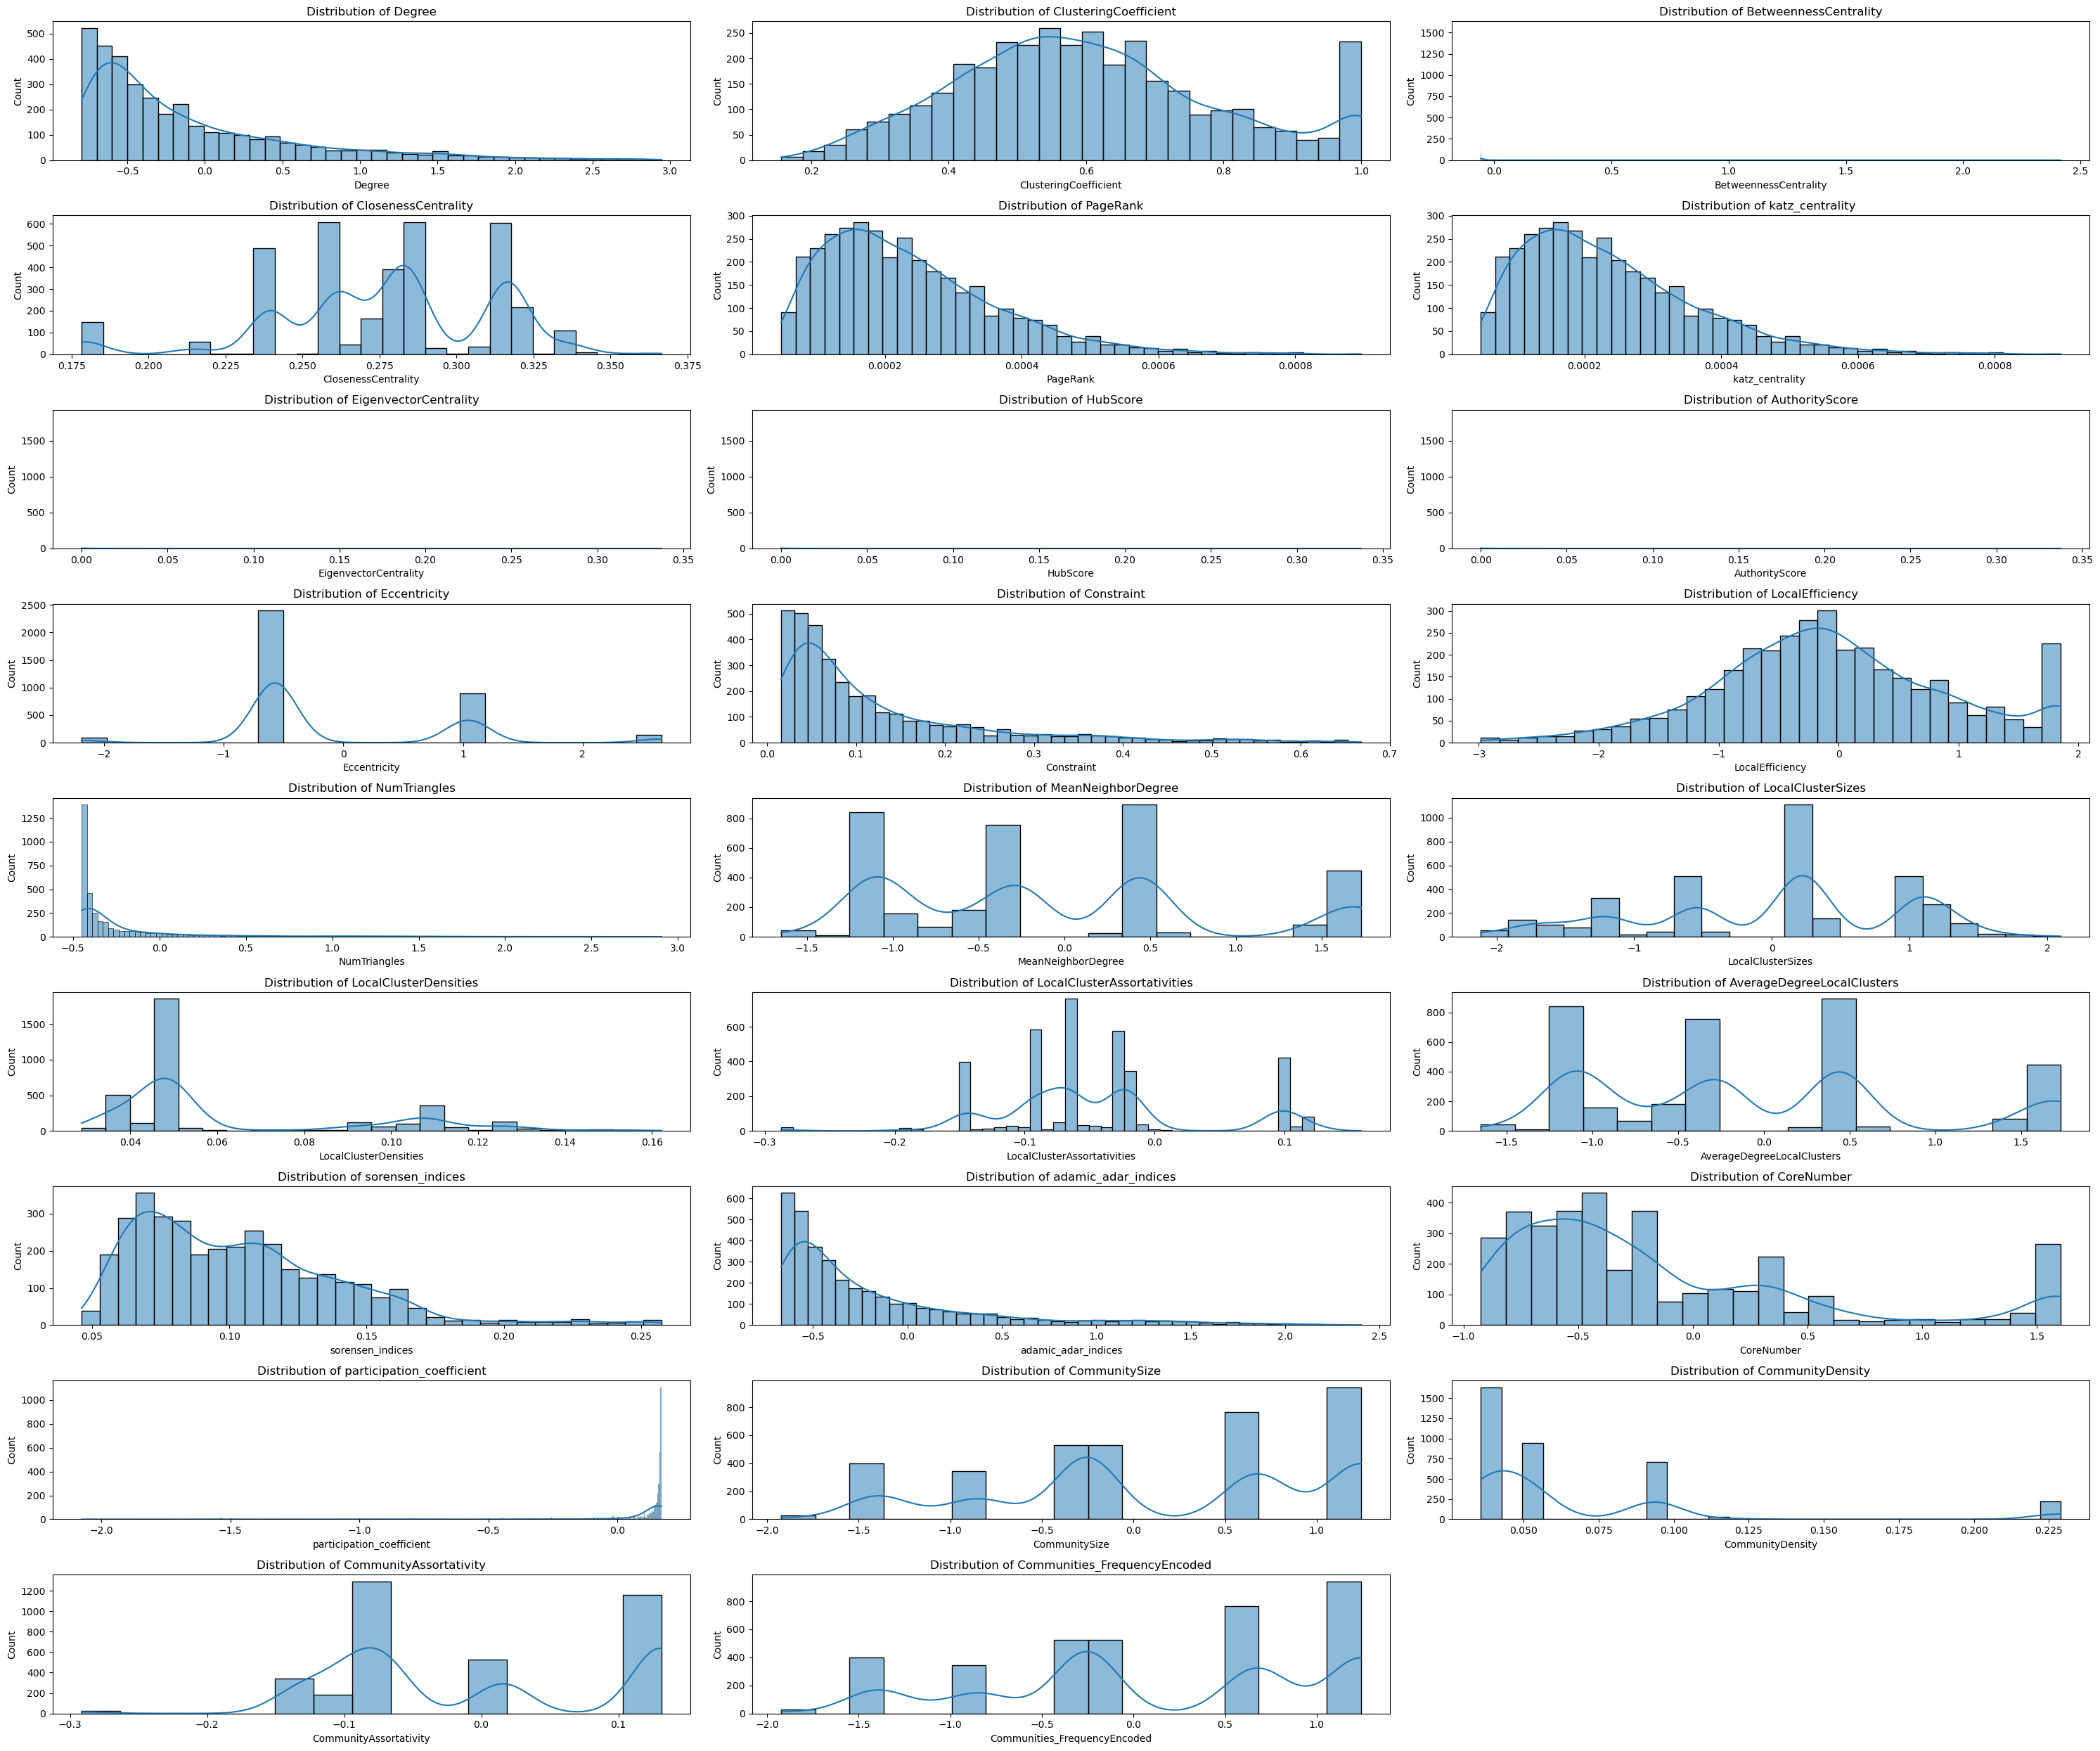

In [29]:
import seaborn as sns

# Visualize the distribution of each feature
plt.figure(figsize=(30, 25))
for i, column in enumerate(cleaned_df.columns[1:], 1):
    plt.subplot(9, 3, i)
    sns.histplot(cleaned_df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

I plotted all the features and every feature looks close to normalized distrubution within a scale and now lets see blot plot how the outliers exist and looks still in the threshold range

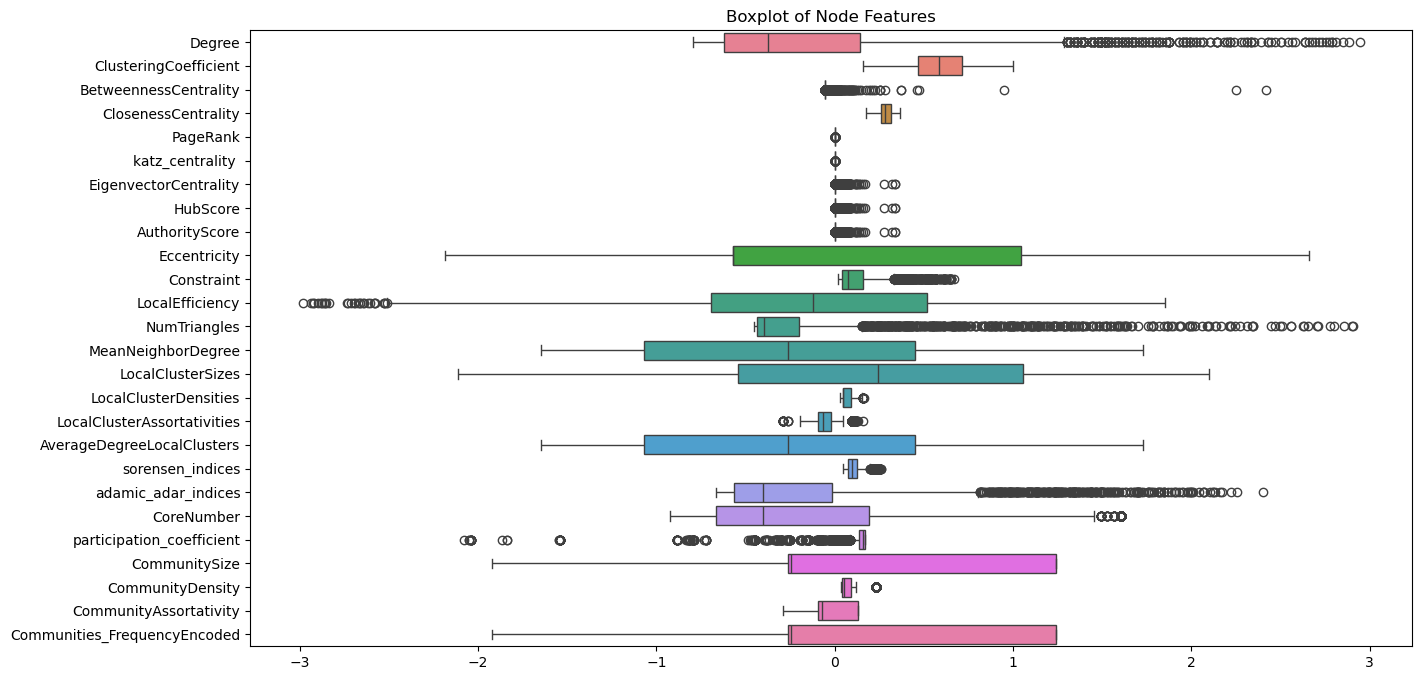

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming cleaned_df is your DataFrame containing the data for the box plot
# Assuming 'Node' is the column you want to exclude from the plot

# Set the figure size
plt.figure(figsize=(15, 8))

# Create a vertical box plot
sns.boxplot(data=cleaned_df.drop(columns=['Node']), orient='h')

# Add title and show the plot
plt.title('Boxplot of Node Features')
plt.show()

/tmp/ipykernel_4325/3068152365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


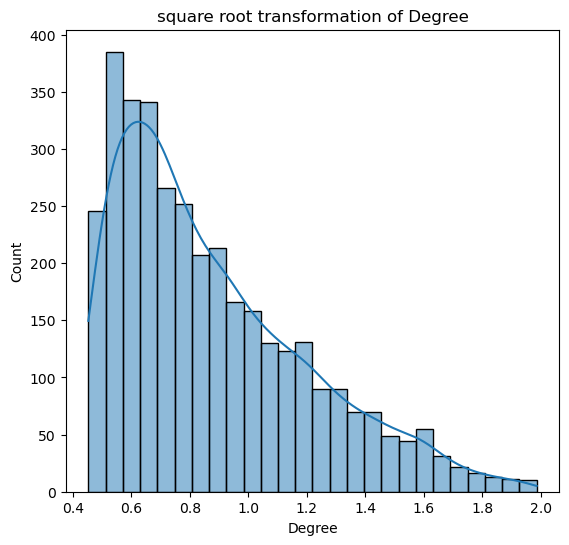

/tmp/ipykernel_4325/3068152365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


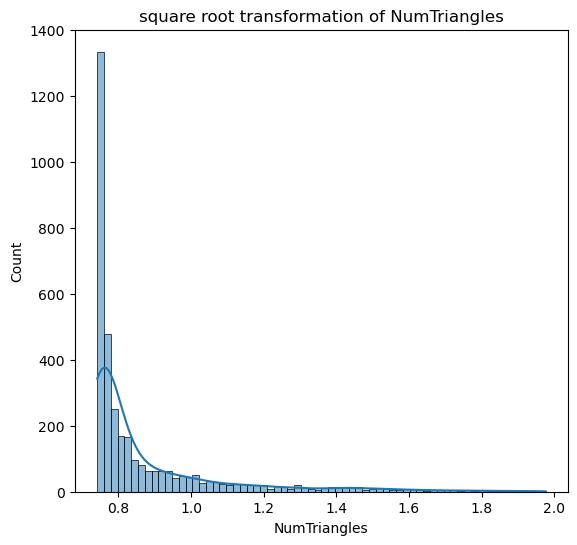

/tmp/ipykernel_4325/3068152365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


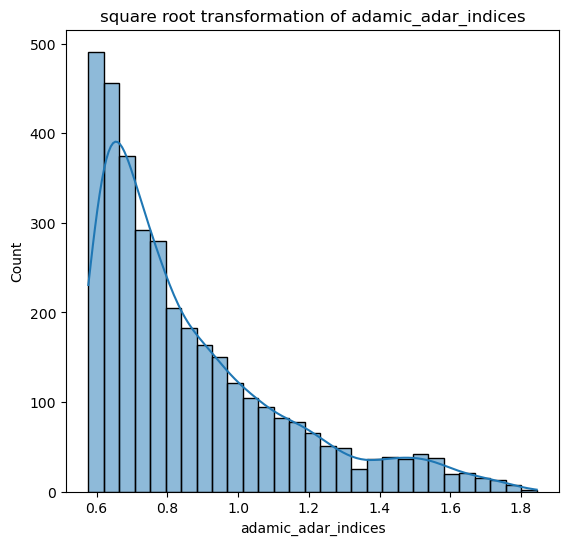

/tmp/ipykernel_4325/3068152365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


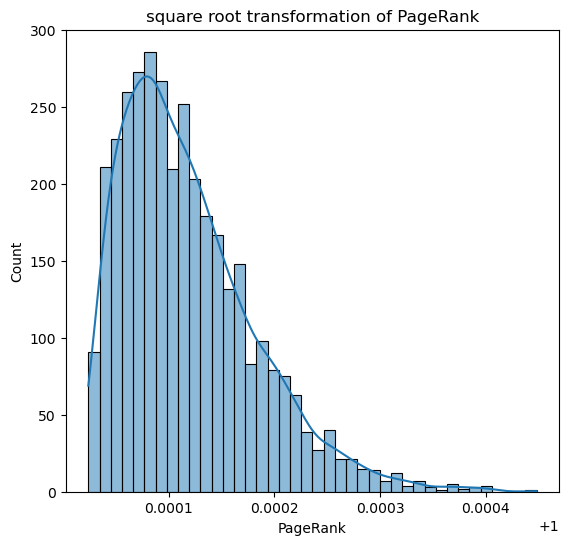

/tmp/ipykernel_4325/3068152365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


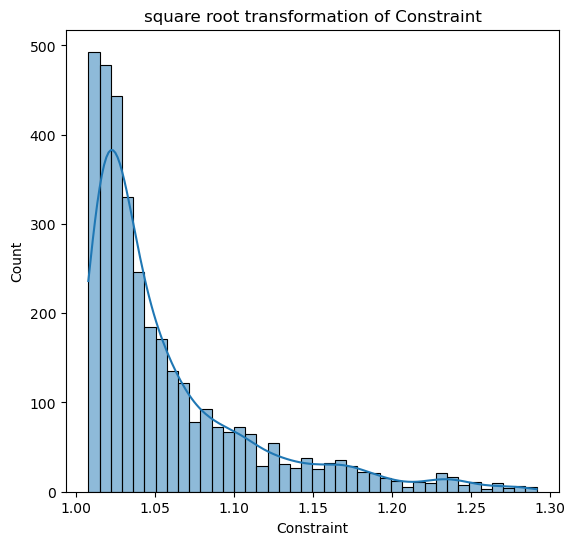

/tmp/ipykernel_4325/3068152365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


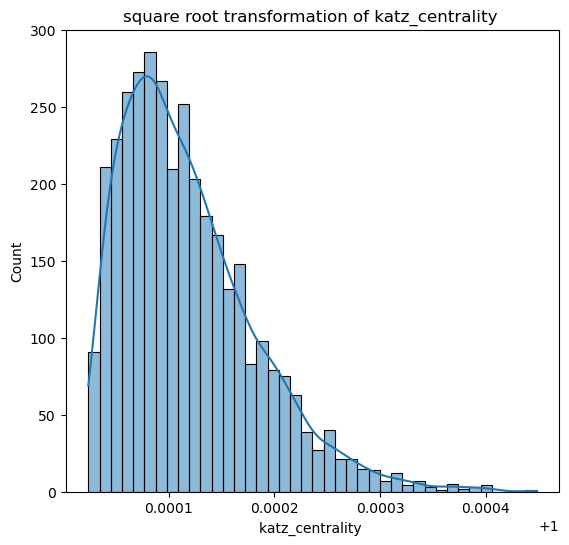

/opt/conda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_4325/3068152365.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)


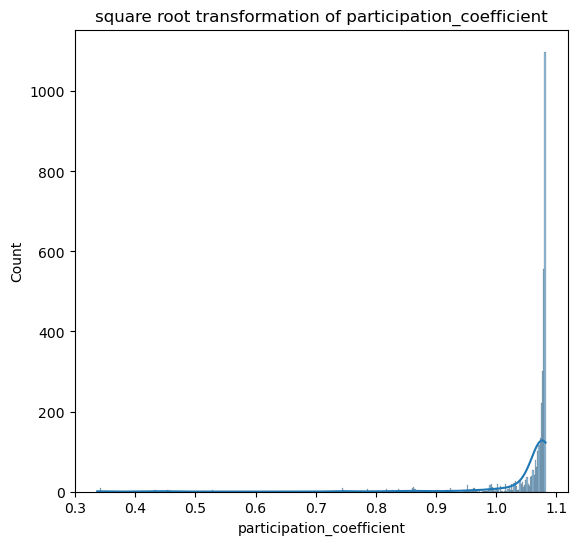

,Node,Degree,ClusteringCoefficient,BetweennessCentrality,ClosenessCentrality,PageRank,katz_centrality,EigenvectorCentrality,HubScore,AuthorityScore,...,LocalClusterAssortativities,AverageDegreeLocalClusters,sorensen_indices,adamic_adar_indices,CoreNumber,participation_coefficient,CommunitySize,CommunityDensity,CommunityAssortativity,Communities_FrequencyEncoded
1,1,0.700547,0.419118,-0.057036,0.261376,1.000118,1.000118,0.000006,0.000006,0.000006,...,-0.141855,-1.206914,0.128317,0.768420,-0.515967,1.078821,-0.849481,0.042446,-0.133841,-0.849481
2,2,0.597675,0.888889,-0.057268,0.261258,1.000100,1.000100,0.000002,0.000002,0.000002,...,-0.141855,-1.206914,0.122203,0.666309,-0.664664,1.073933,-0.849481,0.042446,-0.133841,-0.849481
3,3,0.700547,0.632353,-0.057130,0.261376,1.000113,1.000113,0.000007,0.000007,0.000007,...,-0.141855,-1.206914,0.143140,0.810941,-0.515967,1.078447,-0.849481,0.042446,-0.133841,-0.849481
4,4,0.597675,0.866667,-0.057259,0.261258,1.000116,1.000116,0.000002,0.000002,0.000002,...,-0.141855,-1.206914,0.110459,0.643592,-0.664664,1.074068,-0.849481,0.042446,-0.133841,-0.849481
5,5,0.643779,0.333333,-0.057085,0.261308,1.000101,1.000101,0.000012,0.000012,0.000012,...,-0.141855,-1.206914,0.119667,0.717127,-0.627490,1.076862,-0.849481,0.042446,-0.133841,-0.849481


In [31]:
#Applying square root trannsformation to reduce the right skewedness of the below features

# Features to transform
features_to_transform = ['Degree', 'NumTriangles', 'adamic_adar_indices', 'PageRank', 'Constraint','katz_centrality ','participation_coefficient']

# Apply log transformation
for feature in features_to_transform:
    # To handle zero values, we add 1 before taking the log
    cleaned_df[feature] = np.sqrt(cleaned_df[feature] + 1)

    # Plot original and transformed distributions
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(cleaned_df[feature], kde=True)
    plt.title(f'square root transformation of {feature}')
    plt.show()

# Display the DataFrame with the new log-transformed features
cleaned_df.head()

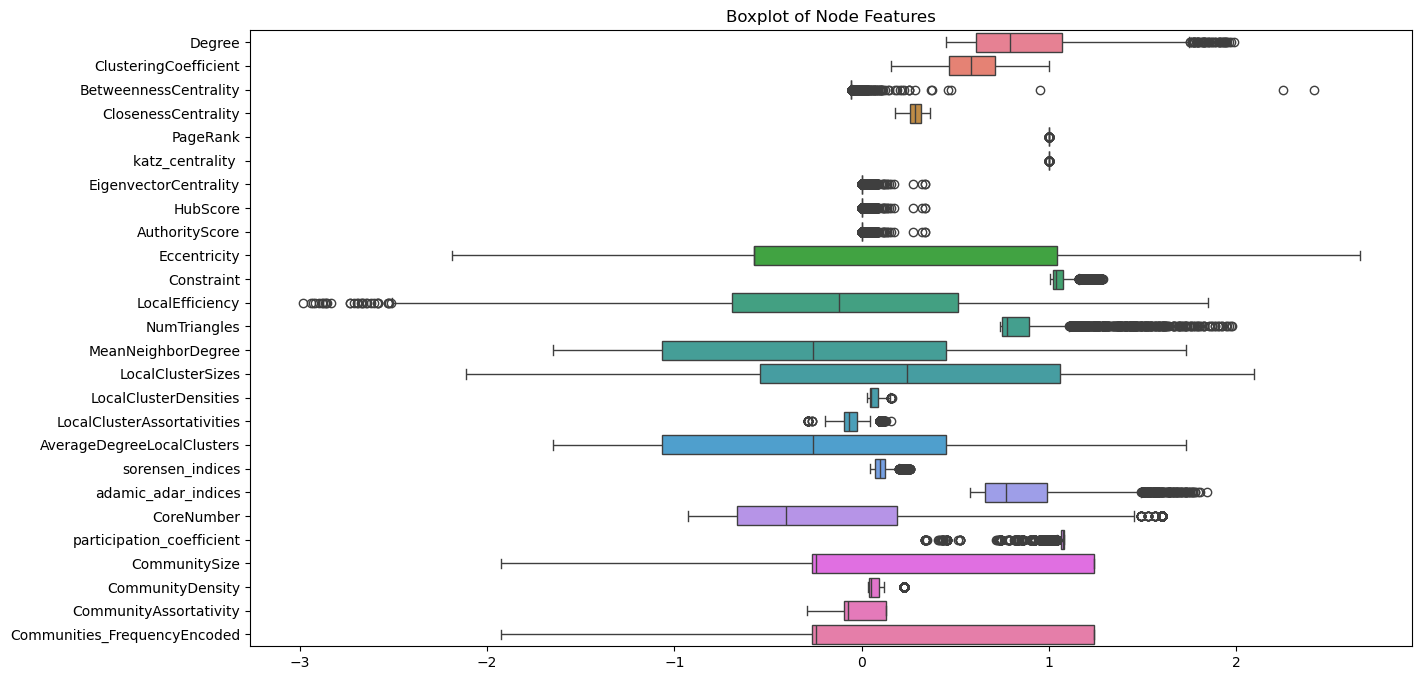

In [32]:
# cleaned_df is your DataFrame containing the data for the box plot
# 'Node' is the column you want to exclude from the plot

# Set the figure size
plt.figure(figsize=(15, 8))

# Create a vertical box plot
sns.boxplot(data=cleaned_df.drop(columns=['Node']), orient='h')

# Add title and show the plot
plt.title('Boxplot of Node Features')
plt.show()

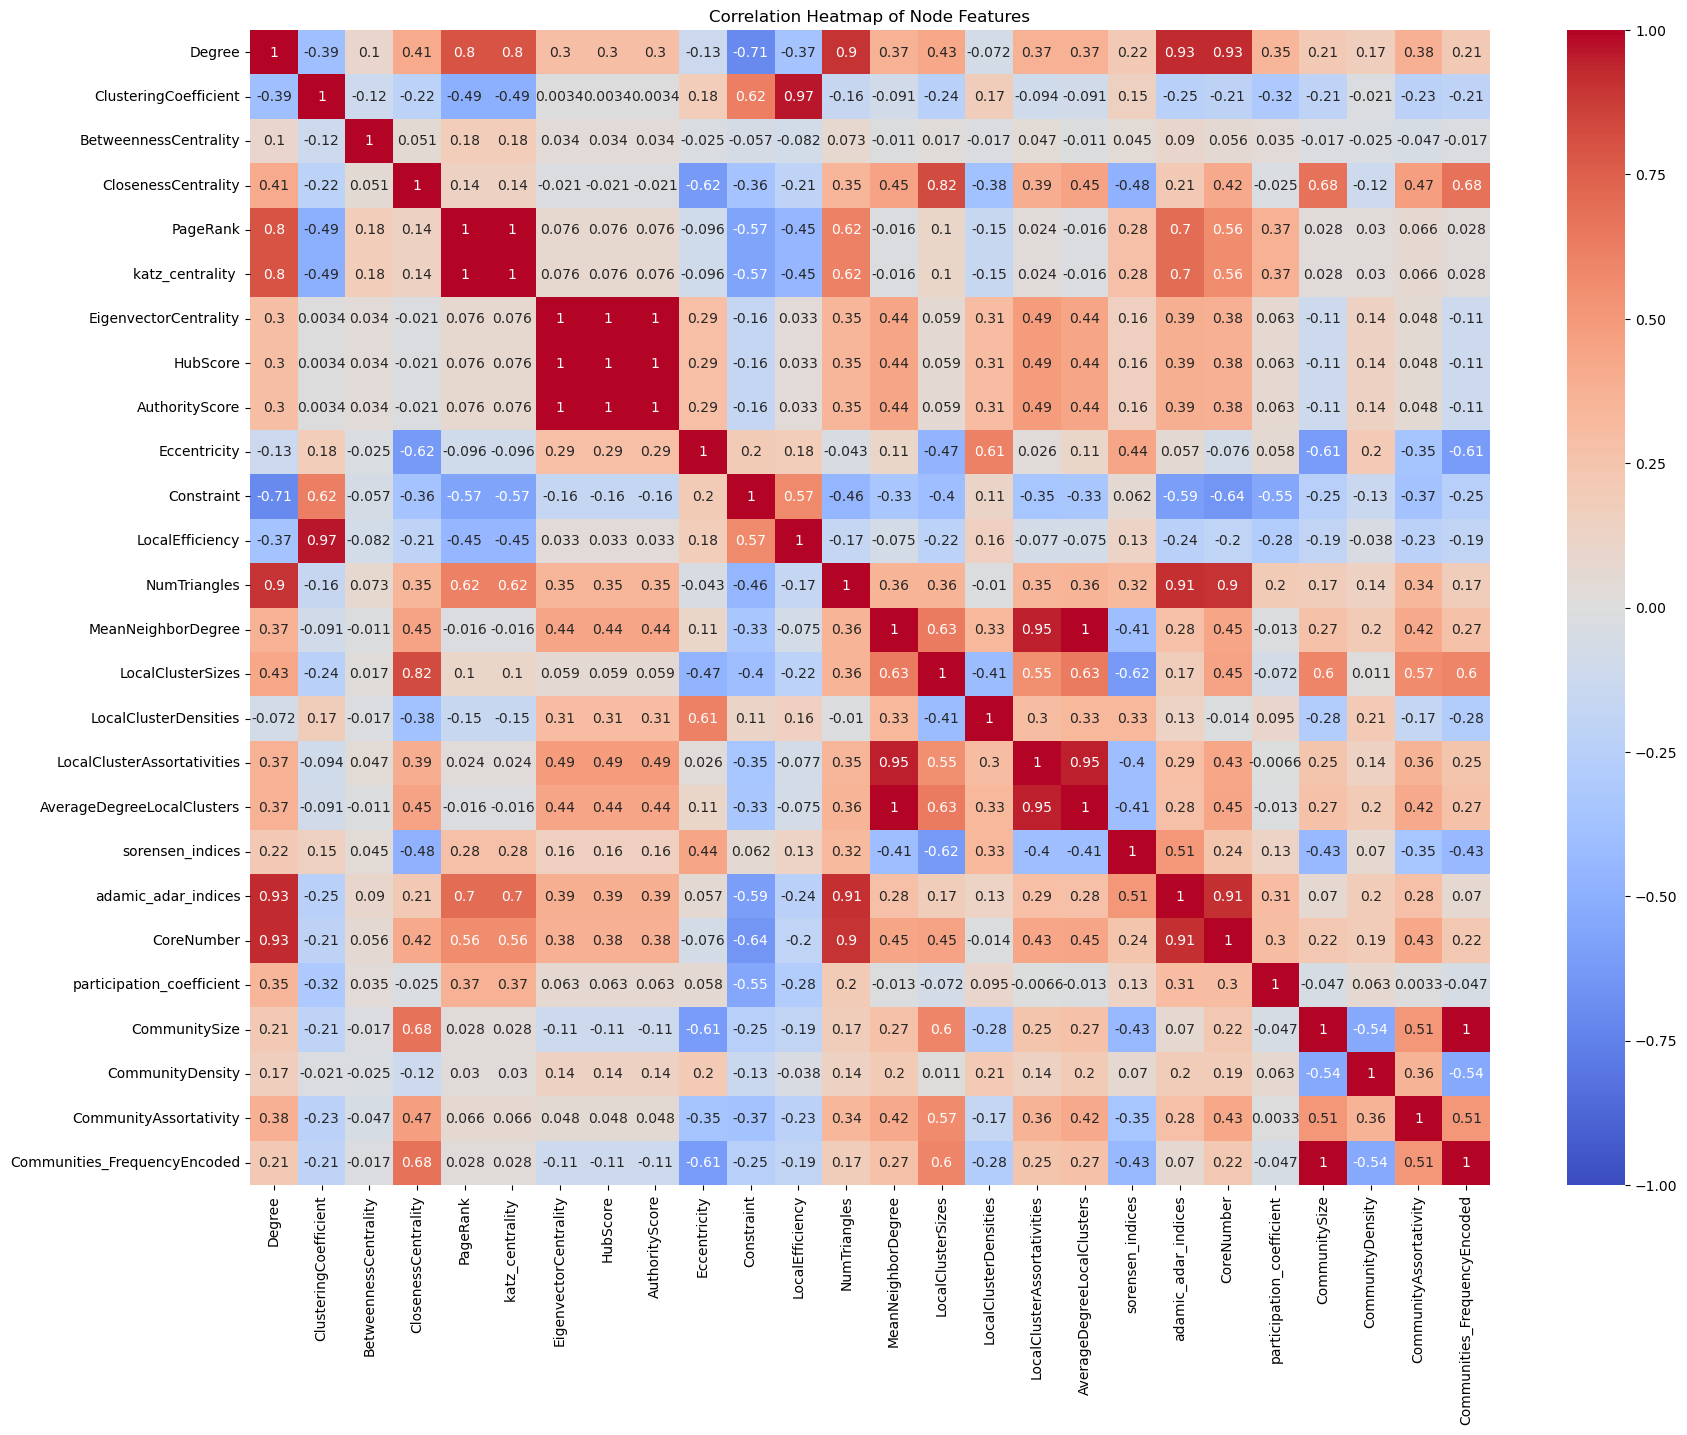

In [33]:
# Correlation heatmap to show relationships between features
plt.figure(figsize=(20, 15))
correlation_matrix = cleaned_df.drop(columns=['Node']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Node Features')
plt.show()

dropped the features which are highly correlated in the above heatmap and preserve the important features to get maximum information for clustering.

In [34]:
df_dropped = cleaned_df.drop(columns=['HubScore','AuthorityScore','LocalClusterAssortativities','Communities_FrequencyEncoded',
                                      'AverageDegreeLocalClusters','NumTriangles','CoreNumber','LocalEfficiency','katz_centrality ','adamic_adar_indices'])

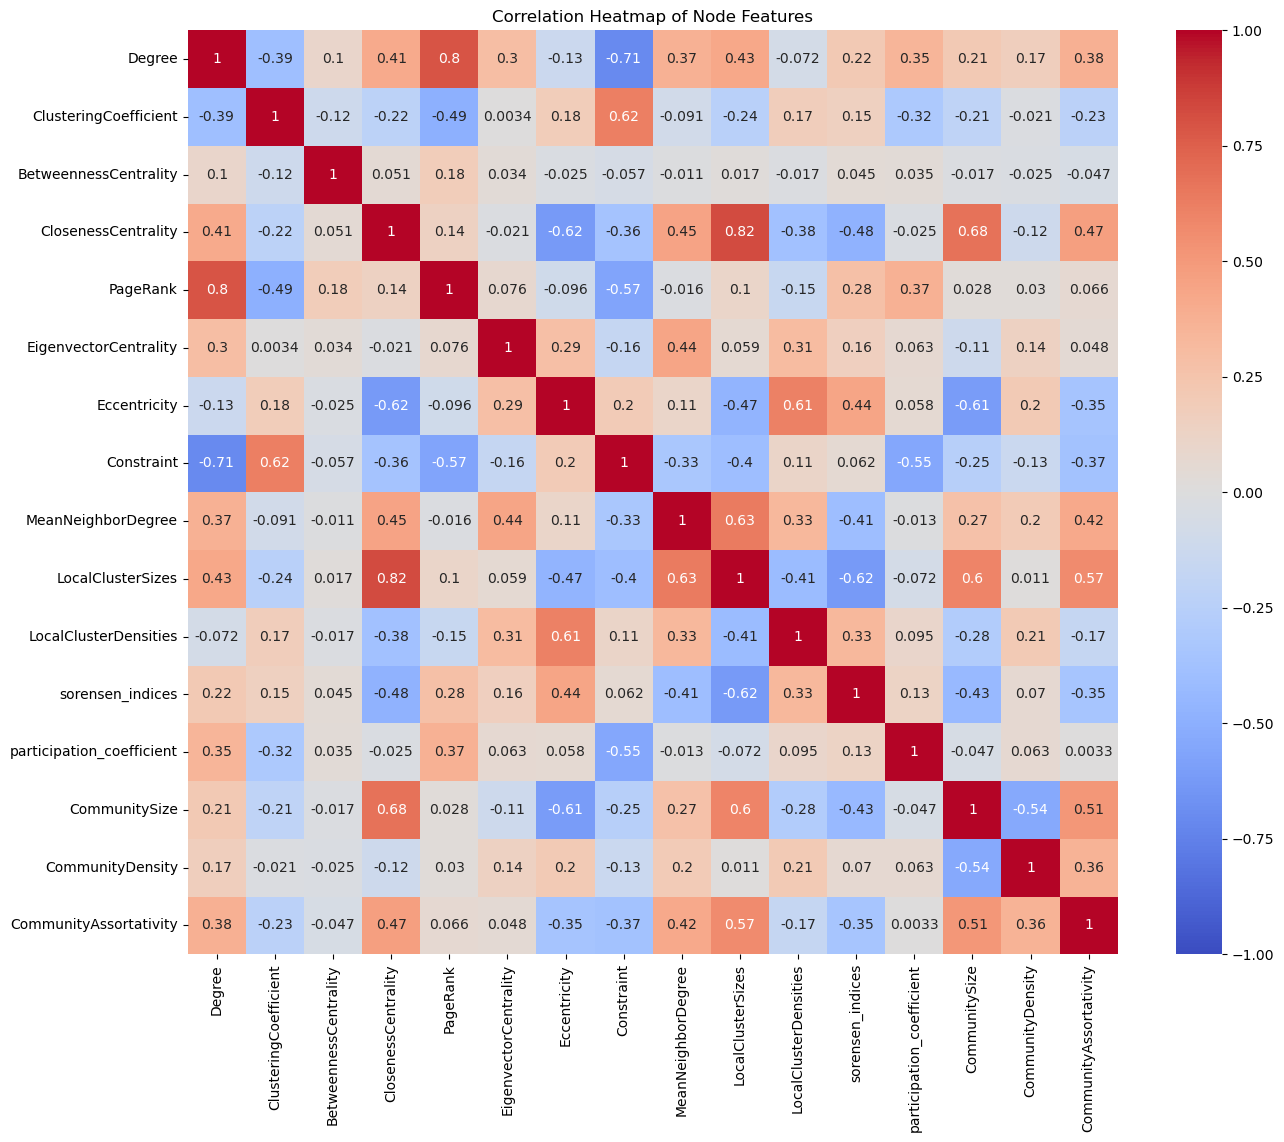

In [35]:
# Correlation heatmap to show relationships between features
plt.figure(figsize=(15, 12))
correlation_matrix = df_dropped.drop(columns=['Node']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Node Features')
plt.show()

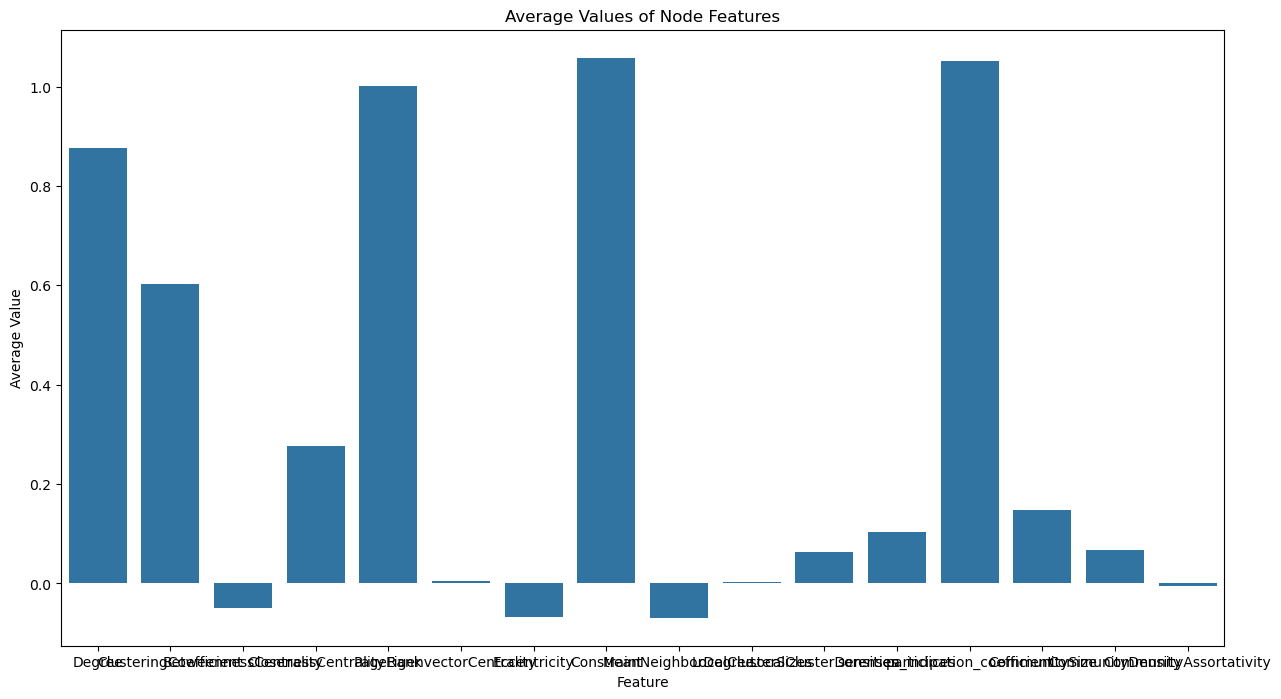

In [42]:
# Bar plot to show the average values of each feature
plt.figure(figsize=(15, 8))
sns.barplot(data=df_dropped.drop(columns=['Node']).mean().reset_index(), x='index', y=0)
plt.title('Average Values of Node Features')
plt.ylabel('Average Value')
plt.xlabel('Feature')
plt.show()

In [43]:
# Check for null values in each column
null_values_per_column = df_dropped.isnull().sum()
print("Null values per column:")
print(null_values_per_column)

Null values per column:
Node                          0
Degree                        0
ClusteringCoefficient         0
BetweennessCentrality         0
ClosenessCentrality           0
PageRank                      0
EigenvectorCentrality         0
Eccentricity                  0
Constraint                    0
MeanNeighborDegree            0
LocalClusterSizes             0
LocalClusterDensities         0
sorensen_indices              0
participation_coefficient    29
CommunitySize                 0
CommunityDensity              0
CommunityAssortativity        0
dtype: int64


In [44]:
df_dropped.shape

(3532, 17)

In [45]:
from sklearn.impute import SimpleImputer

# Impute NaN values only for specific columns with the mean of each column
columns_to_impute = ['participation_coefficient']
imputer = SimpleImputer(strategy='mean')
df_dropped.loc[:, columns_to_impute] = imputer.fit_transform(df_dropped[columns_to_impute])

In [46]:
df_dropped.shape

(3532, 17)

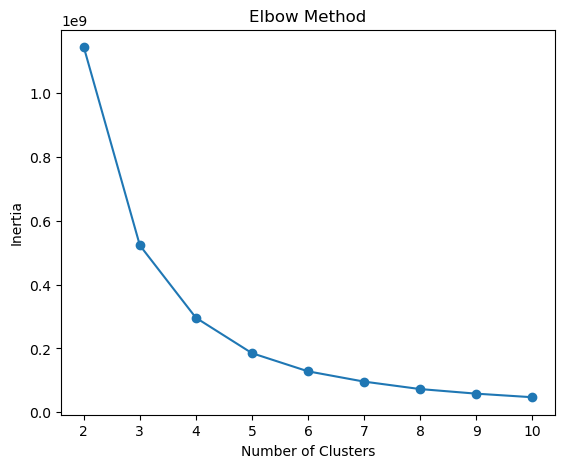

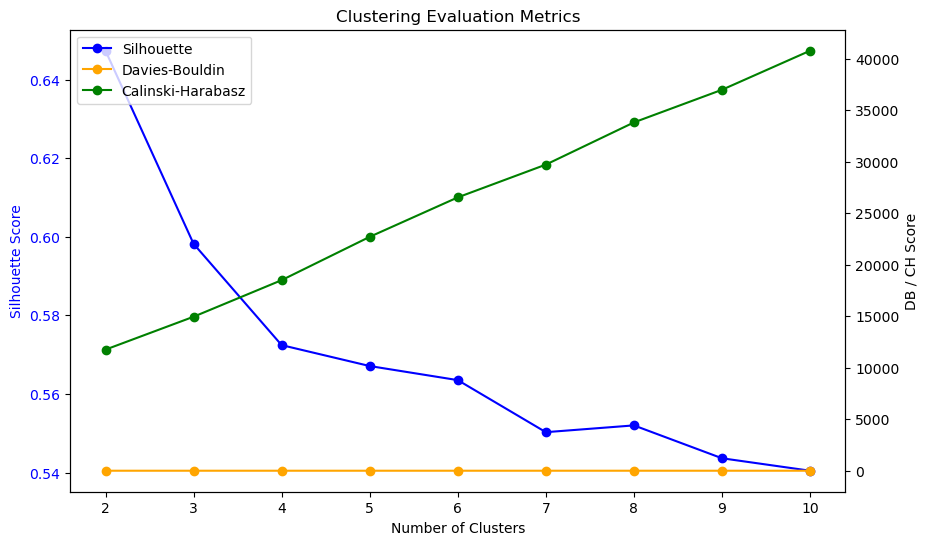

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
inertia = []
silhouette = []
db_score = []
ch_score = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_dropped)

    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_dropped, labels))
    db_score.append(davies_bouldin_score(df_dropped, labels))
    ch_score.append(calinski_harabasz_score(df_dropped, labels))

# Plot Elbow
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot performance scores
fig, ax1 = plt.subplots(figsize=(10, 6))

# Primary Y-axis (Silhouette Score)
ax1.plot(k_values, silhouette, marker='o', color='blue', label='Silhouette')
ax1.set_ylabel('Silhouette Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Number of Clusters')
ax1.set_title('Clustering Evaluation Metrics')

# Secondary Y-axis for Davies-Bouldin and Calinski-Harabasz
ax2 = ax1.twinx()
ax2.plot(k_values, db_score, marker='o', color='orange', label='Davies-Bouldin')
ax2.plot(k_values, ch_score, marker='o', color='green', label='Calinski-Harabasz')
ax2.set_ylabel('DB / CH Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()

In [51]:
best_score = -1
best_model = None
best_k = None

for k in range(2, 11):
    for init_method in ['k-means++', 'random']:
        kmeans = KMeans(n_clusters=k, init=init_method, n_init=10, random_state=42)
        labels = kmeans.fit_predict(df_dropped)
        sil_score = silhouette_score(df_dropped, labels)

        if sil_score > best_score:
            best_score = sil_score
            best_model = kmeans
            best_k = k

print(f"Best K: {best_k}, Silhouette Score: {best_score:.4f}")

Best K: 2, Silhouette Score: 0.6474
